In [72]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python beautifulsoup4

In [73]:
import os

from dotenv import load_dotenv
from typing import List
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END


In [74]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

## CRAG

In [75]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lovdata.no/dokument/NL/lov/2008-06-27-71/*#&#x2a;",
    "https://www.dibk.no/regelverk/byggteknisk-forskrift-tek17",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()


### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document

# Prompt
prompt =ChatPromptTemplate.from_messages(
    [
        ("system", """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:"""),
    ]
)

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})


### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

def retrieve_relevant_documents(state):
    return []


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["retrieval_state"]["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    retrieval_state = {"documents": documents, "question": question}
    state["retrieval_state"] = retrieval_state
    return state


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    retrieval_state = {"documents": documents, "question": question, "generation": generation}
    state["retrieval_state"] = retrieval_state
    return state


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    retrieval_state = {"documents": filtered_docs, "question": question, "web_search": web_search}
    state["retrieval_state"] = retrieval_state
    return state


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    retrieval_state = {"documents": documents, "question": better_question}
    state["retrieval_state"] = retrieval_state
    return state


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["retrieval_state"]["question"]
    documents = state["retrieval_state"]["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    retrieval_state = {"documents": documents, "question": question}
    state["retrieval_state"] = retrieval_state
    return state


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["retrieval_state"]["question"]
    web_search = state["retrieval_state"]["web_search"]
    state["retrieval_state"]["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

binary_score='no'
The responsible applicant is the representative of the developer to the municipality, ensuring that the application contains the necessary information for the municipality to assess compliance with regulations and permits. They coordinate the responsible designers, executors, and controllers, ensuring all tasks are assigned responsibility and are accountable. The responsible applicant is also responsible for finalizing the project by submitting the necessary documentation.


## Reflexion

In [76]:
class MarkedCheckpoint(BaseModel):
    status: str = Field(description="The status of the checkpoint either being Correct, Uncertain, or Incorrect based on the content of the application.")
    reason: str = Field(description="The reason for the status of the checkpoint.")
    


In [77]:
import json


def fill_out_checklist_responder(state):
    print("\n---Filling out Checklist---")
    user_applications = state['user_application_documents']
    checklist = state['checklist']
    retrieval_state = state['retrieval_state']
    documents = retrieval_state['documents']  # Retrieved laws and regulations

    # Combine all application documents into one string
    application_text = "\n\n".join(user_applications)
    # Combine all retrieved documents into one string
    laws_and_regulations = "\n\n".join([doc.page_content for doc in documents])

    marked_checklist = []

    need_retrieval = False  # Flag to determine if retrieval is needed

    for checkpoint in checklist:
        # Construct the prompt with chain-of-thought
        prompt = f"""
You are an expert in building regulations and codes.

First, read the following application documents:

{application_text}

Then, review the following laws and regulations:

{laws_and_regulations}

Now, evaluate the following checkpoint:

"{checkpoint}"

Using the information from the application and the laws, determine whether the checkpoint is 'Correct', 'Incorrect', or 'Uncertain'. Provide a brief reason for your determination.

If you don't have enough information to make a decision, or if the laws and regulations provided are insufficient, mark the status as 'Uncertain' and state that more information is needed.

Provide your answer in the following JSON format:

{{
  "status": "Correct" or "Incorrect" or "Uncertain",
  "reason": "Your reason here."
}}
"""

        # Get the response from the LLM
        response = llm.predict(prompt)
        # Parse the response
        try:
            result = json.loads(response)
            marked_checkpoint = MarkedCheckpoint(
                status=result.get('status', 'Uncertain'),
                reason=result.get('reason', 'No reason provided.')
            )
            # If status is 'Uncertain' due to lack of information, set the retrieval flag
            if marked_checkpoint.status == 'Uncertain' and 'more information' in marked_checkpoint.reason.lower():
                need_retrieval = True
        except json.JSONDecodeError:
            # If parsing fails, mark as Uncertain and set retrieval flag
            marked_checkpoint = MarkedCheckpoint(
                status='Uncertain',
                reason='Could not parse LLM response.'
            )
            need_retrieval = True
        marked_checklist.append(marked_checkpoint)

    # Update the state with the marked checklist
    state['marked_checklist'] = marked_checklist
    state['should_retrieve'] = need_retrieval  # Set the flag in the state
    return state



def decide_next_step_after_fill_out(state):
    """Decide whether to proceed to 'retrieve' or 'marked_checklist_revisor'."""
    if state.get('should_retrieve'):
        print("---DECISION: Need more information, proceeding to 'retrieve'---")
        return "retrieve"
    else:
        print("---DECISION: Enough information, proceeding to 'marked_checklist_revisor'---")
        return "marked_checklist_revisor"

def marked_checklist_revisor(state):
    """Node that revises the marked checklist and decides whether to continue."""
    print("\n---Marked Checklist Revisor---")
    marked_checklist = state['marked_checklist']

    # Prepare the checklist items for review
    checklist_items = [
        {
            "checkpoint": checkpoint,
            "status": item.status,
            "reason": item.reason
        }
        for checkpoint, item in zip(state['checklist'], marked_checklist)
    ]

    # Construct the prompt for the LLM
    prompt = f"""
You are an expert reviewer in building regulations.

Review the following marked checklist items for correctness and consistency:

{json.dumps(checklist_items, indent=2)}

If any of the statuses or reasons seem incorrect or inconsistent, provide the corrected status and reason for those items. If everything is correct, simply reply 'All good'.

Provide your corrections in the same JSON format as above.
"""

    # Get the response from the LLM
    response = llm.predict(prompt)

    if 'All good' in response:
        # No revisions needed
        print("No revisions needed.")
        state['should_continue'] = False
    else:
        try:
            revised_items = json.loads(response)
            # Update the marked checklist with revisions
            for revised_item in revised_items:
                for idx, (checkpoint, item) in enumerate(zip(state['checklist'], marked_checklist)):
                    if checkpoint == revised_item.get('checkpoint'):
                        item.status = revised_item.get('status', item.status)
                        item.reason = revised_item.get('reason', item.reason)
            # After revisions, check if any items are still 'Uncertain'
            for item in marked_checklist:
                if item.status == 'Uncertain':
                    state['should_continue'] = True
                    print("Uncertain items remain after revision.")
                    break
            else:
                state['should_continue'] = False
                print("All items are certain after revision.")
        except json.JSONDecodeError:
            print("Could not parse revision response.")
            state['should_continue'] = True  # Continue if parsing failed

    # Update the state with the revised checklist
    state['marked_checklist'] = marked_checklist
    return state


def decide_to_continue_after_revisor(state):
    """Decide whether to continue processing or end."""
    if state.get('should_continue'):
        print("---DECISION: Looping back to 'fill_out_checklist_responder'---")
        return "fill_out_checklist_responder"
    else:
        print("---DECISION: Process complete---")
        return END


In [78]:
class MarkedCheckpoint(BaseModel):
    status: str = Field(description="The status of the checkpoint either being Correct, Uncertain, or Incorrect based on the content of the application.")
    reason: str = Field(description="The reason for the status of the checkpoint.")
    

class RetrievalState(TypedDict):
    """
    Represents the state of our retrieval graph using CRAG.

    Attributes:
        question: question
        answer: LLMs answer based on the question and context
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: list[str]


class AgentState(TypedDict):
    user_application_documents: list[str]
    retrieval_state: RetrievalState
    checklist: list[str]
    marked_checklist: list[MarkedCheckpoint]
    reflection: str
    grading: str
    should_retrieve: bool  # Added to control whether to retrieve
    should_continue: bool  # To control the loop from revisor



In [86]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)
workflow.add_node("fill_out_checklist_responder", fill_out_checklist_responder)
workflow.add_node("marked_checklist_revisor", marked_checklist_revisor)

# Build edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", "fill_out_checklist_responder")
workflow.add_conditional_edges(
    "fill_out_checklist_responder",
    decide_next_step_after_fill_out,
    {
        "retrieve": "retrieve",
        "marked_checklist_revisor": "marked_checklist_revisor",
    },
)
workflow.add_conditional_edges(
    "marked_checklist_revisor",
    decide_to_continue_after_revisor,
    {
        "fill_out_checklist_responder": "fill_out_checklist_responder",
        END: END,
    },
)


# Compile the graph
app = workflow.compile()

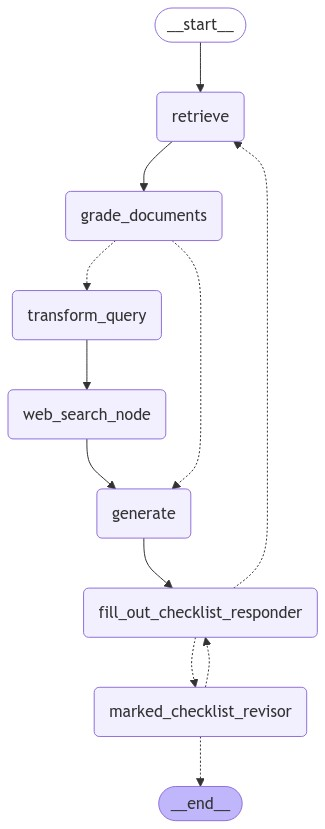

In [87]:
from IPython.display import Image

def visualize(graph: StateGraph) -> None:
    return Image(graph.get_graph().draw_mermaid_png())
visualize(app)

In [90]:
# Sample user application documents
user_application_documents = [
    "The applicant wants to build a two-story house with a basement. The proposed building height is 9 meters. The building will be located 5 meters from the property line.",
    "The applicant intends to add a fourth floor to an existing three-story building, increasing the total height to 15 meters. No environmental impact assessment has been provided."
    "The building will be constructed 10 meters from the riverbank",
]

# Sample checklist
checklist = [
    "The building height does not exceed the maximum allowed height of 10 meters.",
    "The building complies with zoning regulations for residential areas.",
    "The proposed construction does not infringe on neighboring properties.",
    "An environmental impact assessment has been conducted.",
    "Forbud mot tiltak mv. langs sjø og vassdrag",
]
# Initial state
initial_state = {
    'user_application_documents': user_application_documents,
    'retrieval_state': {
        'question': "Building regulations for residential constructions",
        'generation': '',
        'web_search': '',
        'documents': []  # Will be filled by the retrieval function
    },
    'checklist': checklist,
    'marked_checklist': [],
    'reflection': '',
    'grading': '',
    'should_retrieve': True,  # Start with False
    'should_continue': True,    # Start with True to enter the loop

}

# Run the agent
final_state = app.invoke(initial_state)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---

---Filling out Checklist---
---DECISION: Enough information, proceeding to 'marked_checklist_revisor'---

---Marked Checklist Revisor---
All items are certain after revision.
---DECISION: Process complete---


In [91]:
final_state

{'user_application_documents': ['The applicant wants to build a two-story house with a basement. The proposed building height is 9 meters. The building will be located 5 meters from the property line.',
  'The applicant intends to add a fourth floor to an existing three-story building, increasing the total height to 15 meters. No environmental impact assessment has been provided.The building will be constructed 10 meters from the riverbank'],
 'retrieval_state': {'documents': [Document(metadata={}, page_content="Building Codes and Regulations for Construction Projects | Building Radar Building Codes and Regulations: Ensuring Compliance in Construction Projects Adhering to building codes and regulations is crucial for ensuring safety, quality, and legal compliance in construction industry. For more information on how Building Radar can assist with compliance and project management, visit\xa0Building Radar’s official site\xa0and their\xa0construction blog. Adhering to building codes and 